<a href="https://colab.research.google.com/github/SarahWohlford/SW_Projects-in-Machine-Learning-and-AI_P/blob/main/SW_HW3_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1 (50 points)
In this part you will implement a neural network from scratch. You cannot use any existing
Deep Learning Framework. You can utilize NumPy and Pandas libraries to perform efficient
calculations. Refer to Lecture 5 slides for details on computations required.

Write a Class called NeuralNetwork that has at least the following methods (you are free to add
your own methods too):

a. Initialization method.

b. Forward propagation method that performs forward propagation calculations.

c. Backward propagation method that implements the backpropagation algorithm
discussed in class.

d. Train method that includes the code for gradient descent.

e.  Cost method that calculates the loss function.

f.
Predict method that calculates the predictions for the test set.
Test your NeuralNetwork Class with the dataset you selected. If the dataset is big, you may
notice inefficiencies in runtime. Try incorporating different versions of gradient descent to
improve that (Minibatch, Stochastic etc.). You may choose to use only a subset of your data for
this task (or any other technique). Explain which technique you followed and why.

ALSO: My data has 3 classes:

0 = no diabetes,

1 = prediabetes,

2 = diabetes.

So I had to do stuff to accommodate this

also sorry for all the comments they are mostly to help me

My data set: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset 250,000+ data points I choose 15 out of the 22 features

May use a section of 10,000 data points for effiecntsy

Test your NeuralNetwork Class with the dataset you selected. If the dataset is big, you may
notice inefficiencies in runtime. Try incorporating different versions of gradient descent to
improve that (Minibatch, Stochastic etc.). You may choose to use only a subset of your data for
this task (or any other technique). Explain which technique you followed and why.

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split  # For splitting into training and test sets
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # For preprocessing features and labels

# Load Dataset
from google.colab import files
uploaded = files.upload()
uploaded_filename = list(uploaded.keys())[0]
df = pd.read_csv(uploaded_filename)

# Preprocess Data
X = df.drop("Diabetes_012", axis=1).values  # Remove target column, keep feature values
y = df["Diabetes_012"].values.reshape(-1, 1)  # Target column, reshaped into column vector

# One-hot encode target (3 classes → each becomes a vector of length 3) because 3 vals no diabetes, pre dibetic, and diabetic
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)  #class 2 → [0, 0, 1]

# Standardize features to mean=0, std=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y
)

class NeuralNetwork:
    #a. Initialization method.
    def __init__(self, layer_sizes, learning_rate=0.01, seed=16):
        np.random.seed(seed)  # Set random seed 16 is my fav number
        self.layer_sizes = layer_sizes  # Ex [21, 32, 16, 3]
        self.learning_rate = learning_rate
        self.num_layers = len(layer_sizes) - 1  # Number of weight/bias layers (excluding input)

        # Initialize weights and biases as lists for each layer
        self.W = []  # Weight
        self.b = []  # Bias
        for i in range(1, len(layer_sizes)):
            # He initialization for ReLU: W ~ N(0, sqrt(2 / n_l-1))
            weight_matrix = np.random.randn(layer_sizes[i], layer_sizes[i - 1]) * np.sqrt(2. / layer_sizes[i - 1])
            bias_vector = np.zeros((layer_sizes[i], 1))  # Start all biases at 0
            self.W.append(weight_matrix)
            self.b.append(bias_vector)

    def _relu(self, z):
         # ReLU activation: max(0, z)
        return np.maximum(0, z)

    def _relu_derivative(self, z):
        # Derivative: 1 if z > 0, else 0
        return (z > 0).astype(float)

    def _softmax(self, z):
        # Softmax activation for output layer (multi-class classification)
        # a_i = exp(z_i) / sum(exp(z_j)) across classes j
        e_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return e_z / e_z.sum(axis=0, keepdims=True)

    #b. Forward propagation method that performs forward propagation calculations.
    def forward(self, X):
        # Shape: (features, samples) — A[0] = X
        A = X.T  # Transpose: now shape is (features, samples)
        cache_A = [A]  # Store activations (A0 = input)
        cache_Z = []   # Store pre-activation values Z

        # Forward pass through hidden layers
        # Z^[l] = W^[l] · A^[l-1] + b^[l]
        for l in range(self.num_layers - 1):
            Z = self.W[l] @ A + self.b[l]  # Linear transformation: Z = W*X + b
            # A^[l] = ReLU(Z^[l])
            A = self._relu(Z)  # Apply ReLU
            cache_Z.append(Z)  # Save Z for backprop
            cache_A.append(A)  # Save A for next layer

        # Forward pass through output layer
        # Z^[L] = W^[L] · A^[L-1] + b^[L]
        ZL = self.W[-1] @ A + self.b[-1]  # Final layer linear transform
         # A^[L] = softmax(Z^[L])
        AL = self._softmax(ZL)  # Output probabilities
        cache_Z.append(ZL)  # Save ZL
        cache_A.append(AL)  # Save AL

        return AL, cache_A, cache_Z  # Return final output and caches

    def compute_cost(self, Y_hat, Y):
        m = Y.shape[0]  # Number of examples
        # Cross-entropy loss: sum over true labels * log(predicted)
        # L = -1/m * sum over all samples [ y_k * log(y_hat_k) ]
        loss = -np.sum(Y.T * np.log(Y_hat + 1e-8)) / m  # Add epsilon to avoid log(0)
        return loss

    #c. Backward propagation method that implements the backpropagation algorithm discussed in class. (I tried)
    def backward(self, X, Y, cache_A, cache_Z):
        m = X.shape[0]  # Number of examples
        Y = Y.T  # Shape: (classes, samples)

        #gradient storage
        grads_W = [None] * self.num_layers # dW^[l]
        grads_b = [None] * self.num_layers # db^[l]

        #Output Layer
        # sigma^[L] = A^[L] - Y
        dZ = cache_A[-1] - Y  # Derivative of loss w.r.t. output Z
        # dW^[L] = sigma^[L] · (A^[L-1])^T / m
        grads_W[-1] = dZ @ cache_A[-2].T / m  # dW = dZ * A_prev.T
        # db^[L] = sum(sigma^[L], axis=1) / m
        grads_b[-1] = np.sum(dZ, axis=1, keepdims=True) / m  # db = sum over dZ
        # dA^[L-1] = (W^[L])^T · sigma^[L]
        dA_prev = self.W[-1].T @ dZ  # Propagate back: dA_prev = W.T * dZ

        #Hidden Layers (reverse)
        for l in reversed(range(self.num_layers - 1)):
            # sigma^[l] = dA^[l] * ReLU'(Z^[l]) (chain rule)
            dZ = dA_prev * self._relu_derivative(cache_Z[l])  # Chain rule w/ ReLU derivative
            # dW^[l] = sigma^[l] · (A^[l-1])^T / m
            grads_W[l] = dZ @ cache_A[l].T / m  # Gradient for weights
            # db^[l] = sum(sigma^[l], axis=1) / m
            grads_b[l] = np.sum(dZ, axis=1, keepdims=True) / m  # Gradient for biases
            # dA^[l-1] = (W^[l])^T · sigma^[l]
            dA_prev = self.W[l].T @ dZ  # Propagate to earlier layer

        return grads_W, grads_b  # Return lists of gradients

    def update_params(self, grads_W, grads_b):
        for l in range(self.num_layers):
            # W^[l] := W^[l] - n · dW^[l]
            self.W[l] -= self.learning_rate * grads_W[l]  # Gradient descent step for weights
            # b^[l] := b^[l] - n · db^[l]
            self.b[l] -= self.learning_rate * grads_b[l]  # Gradient descent step for biases

    #Train method that includes the code for gradient descent.
    def train(self, X, Y, epochs=1000, print_cost=False):
        for i in range(epochs):
            # Step 1: Forward pass
            Y_hat, cache_A, cache_Z = self.forward(X)

            # Step 2: Compute cost
            cost = self.compute_cost(Y_hat, Y)

            # Step 3: Backpropagation
            grads_W, grads_b = self.backward(X, Y, cache_A, cache_Z)

            # Step 4: Update weights and biases
            self.update_params(grads_W, grads_b)

            # Optionally print cost every 100 iterations
            if print_cost and i % 100 == 0:
                print("Epoch", i, "Cost =", round(cost, 4))

    def train_mini_batch(self, X, Y, epochs=1000, batch_size=64, print_cost=False):
        m = X.shape[0]  # number of training examples

        for epoch in range(epochs):
            # Shuffle the data
            permutation = np.random.permutation(m)
            X_shuffled = X[permutation]
            Y_shuffled = Y[permutation]

            for i in range(0, m, batch_size):
                # Get mini-batch
                X_batch = X_shuffled[i:i+batch_size]
                Y_batch = Y_shuffled[i:i+batch_size]

                # Forward pass
                Y_hat, cache_A, cache_Z = self.forward(X_batch)

                # Backward pass
                grads_W, grads_b = self.backward(X_batch, Y_batch, cache_A, cache_Z)

                # Parameter update
                self.update_params(grads_W, grads_b)

            # Compute cost for full epoch
            if print_cost and epoch % 100 == 0:
                Y_hat_full, _, _ = self.forward(X)
                cost = self.compute_cost(Y_hat_full, Y)
                print("Epoch", epoch, "Cost =", round(cost, 4))

    #Predict method that calculates the predictions for the test set.
    def predict(self, X):
        Y_hat, _, _ = self.forward(X)  # Get output probabilities
        return np.argmax(Y_hat, axis=0)  # Pick class with highest prob per sample

    #Predict for mini batch
    def predict_mini_batch(self, X, batch_size=64):
        m = X.shape[0]
        predictions = []

        for i in range(0, m, batch_size):
            X_batch = X[i:i+batch_size]
            Y_hat, _, _ = self.forward(X_batch)  # Get probabilities
            batch_preds = np.argmax(Y_hat, axis=0)  # Convert to class labels
            predictions.extend(batch_preds)

        return np.array(predictions)

# get actual results
#Train Model with Mini-Batch Gradient Descent
nn = NeuralNetwork(layer_sizes=[21, 32, 16, 3], learning_rate=0.05)
nn.train_mini_batch(X_train, y_train, epochs=1000, batch_size=64, print_cost=True)

#Evaluate Accuracy Using Mini-Batch Prediction
preds = nn.predict_mini_batch(X_test, batch_size=64)
y_true = np.argmax(y_test, axis=1)

accuracy = np.mean(preds == y_true) * 100
print(f"\nMini-Batch Test Accuracy: {accuracy:.2f}%")

Saving diabetes_012_health_indicators_BRFSS2015.csv to diabetes_012_health_indicators_BRFSS2015 (1).csv
Epoch 0 Cost = 0.3992
Epoch 100 Cost = 0.3871
Epoch 200 Cost = 0.3867
Epoch 300 Cost = 0.3855
Epoch 400 Cost = 0.3852
Epoch 500 Cost = 0.3849
Epoch 600 Cost = 0.3851
Epoch 700 Cost = 0.3843
Epoch 800 Cost = 0.385
Epoch 900 Cost = 0.3852

Mini-Batch Test Accuracy: 84.61%


This took 11 muinets to run on my computer maybe too many loops I did less in part 2 :/

The cost started at 0.3992 and decreased to 0.3842 --> slow but consistent convergence. Most of the improvement happend in the first 300-400 epochs.
After that it plateaued --> the model had reached a stable minimum.

84.61% acturacy --> pretty high good accuracy

Part 2 (50 points)
In this part you will implement a 2-layer neural network using any Deep Learning Framework
(e.g., TensorFlow, PyTorch etc.).   
You should pick a Deep Learning Framework that you would like to use to implement your 2
layer Neural Network.  **I picked PyTorch**

###Task 1 (5 points): Assuming you are not familiar with the framework, in this part of the
homework you will present your research describing the resources you used to learn the
framework (must include links to all resources). Clearly explain why you needed a particular
resource for implementing a 2-layer Neural Network (NN). (Consider how you will keep track of
all the computations in a NN i.e., what libraries/tools do you need within this framework.)
For example, some of the known resources for TensorFlow and PyTorch are:
https://www.tensorflow.org/guide/autodiff
https://www.tensorflow.org/api_docs/python/tf/GradientTape
https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
Hint: You need to figure out the APIs/packages used to implement forward propagation and
backward propagation.

I picked PyTorch

PyTorch is good for building custom neural networks with full control over forward and backward passes. Its seems its easier to understand and use than TensorFlow.

Resources Used:

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
I used this to understand the nn.Module class(structure), how to define layers, and other inforamtion about implmenting forward pass.

https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
This helped me understand how automatic differentiation works in PyTorch, I used it for backpropagation and gradient computation.

https://pytorch.org/docs/stable/optim.html
I used this to understand how to apply my optimizer Adam(updates weights during training).

https://pytorch.org/docs/stable/nn.functional.html
Why: Info about activation functions like ReLU and softmax, used in the hidden and output layers.

https://pytorch.org/docs/stable/tensors.html
Helped with understanding: tensor shapes and broadcasting used in the model.

Once you have figured out the resources you need for the project, you should design and implement your project. The project must include the following steps (it’s not limited to these steps):


1. Exploratory Data Analysis (Can include data cleaning, visualization etc.)

My data was pretty clean and the cleaning I did do was done in part 1

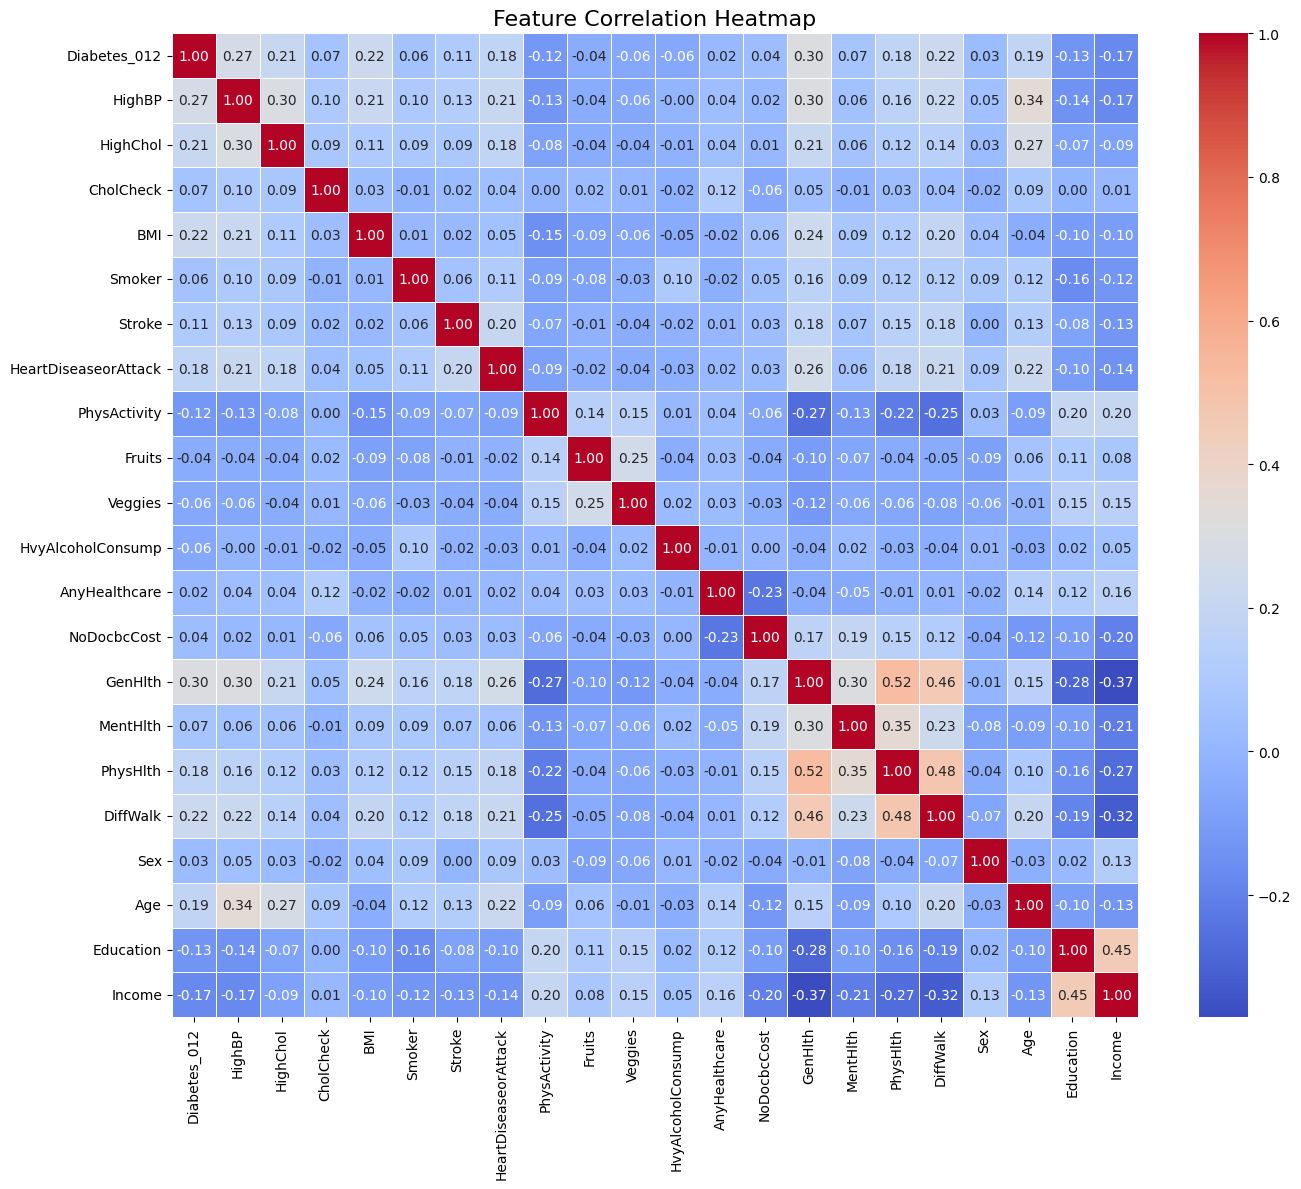

Diabetes_012
0.0    0.842412
2.0    0.139333
1.0    0.018255
Name: proportion, dtype: float64


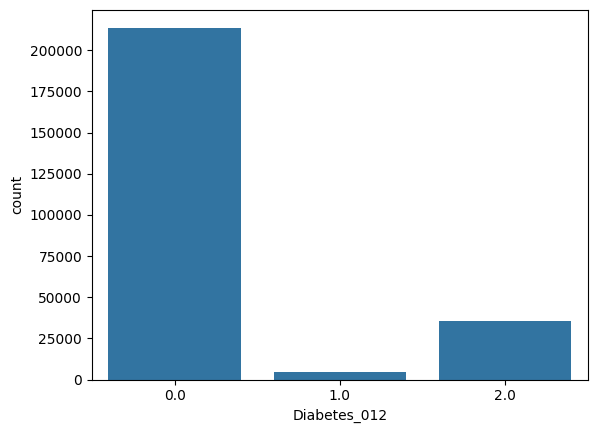

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(),
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            linewidths=0.5)

plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
#Visulization of diffrent targets
print(df["Diabetes_012"].value_counts(normalize=True))
sns.countplot(x="Diabetes_012", data=df)
plt.show()


2. Perform a train-dev-test split.

I split the dataset using train_test_split from sklearn.model_selection. 80% of the data was used for training and 20% for testing. The stratify=y argument ensured class balance across splits.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F

# Slight data fix
X = df.drop("Diabetes_012", axis=1).values
y = df["Diabetes_012"].astype(int).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# X and Y train
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

3. Implement forward propagation (clearly describe the activation functions and other
hyper-parameters you are using).

About: 2-layer neural network with ReLU as activation function in the hidden layers and softmax in the output layer.

Input Layer: 21 features

Hidden Layer 1: 32 neurons (ReLU)

Hidden Layer 2: 16 neurons (ReLU)

Output Layer: 3 neurons (Softmax)

In [8]:
import torch.nn as nn

class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # init
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        # ReLU
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out  # logits

4. Compute the final cost function.

In [9]:
final_cost = nn.CrossEntropyLoss()

5. Implement gradient descent (any variant of gradient descent depending upon your
data and project can be used) to train your model. In this step it is up to you as someone
in charge of their project to improvise using optimization algorithms (Adams, RMSProp
etc.) and/or regularization. Experiment with normalized inputs i.e. comment on how
your model performs when the inputs are normalized.

I used Adams

In [10]:
model = TwoLayerNN(input_size=21, hidden_size=32, output_size=3)
# L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# Training loop
epochs = 100
for epoch in range(epochs):
    outputs = model(X_train_tensor)
    loss = final_cost(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Print loss every 10
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 1.0253
Epoch 10: Loss = 0.4458
Epoch 20: Loss = 0.4240
Epoch 30: Loss = 0.4093
Epoch 40: Loss = 0.4018
Epoch 50: Loss = 0.3983
Epoch 60: Loss = 0.3963
Epoch 70: Loss = 0.3950
Epoch 80: Loss = 0.3941
Epoch 90: Loss = 0.3936


Loss decreased from 1.20 to 0.39 over 100 epochs--> the model was learning well. Most of the improvement happened in the first 30-50 then slowed down/ plateaued

6. Present the results using the test set.

In [13]:
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predictions = torch.argmax(test_outputs, dim=1)
    # Predict accuracy
    accuracy = (predictions == y_test_tensor).float().mean().item() * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 84.85%


84.85% acturacy --> pretty high good accuracy

Task 3 (10 points): In task 2 describe how you selected the hyperparameters. What was the
rationale behind the technique you used? Did you use regularization? Why, or why not? Did you use
an optimization algorithm? Why or why not?

In Task 2, I implemented a two-layer neural network using PyTorch on my dataset.

Hyperparameters design decisions:

Architecture and hyperparameters
Model: 2-layer neural network
Hidden size: 32 neurons
Input size: 21 features
Output size: 3 classes (multi-class classification)
Activation function: ReLU
Loss function: CrossEntropyLoss
Optimizer: Adam
Learning rate: 0.01
Weight decay: 1e-4 (L2 regularization) --> Based on Adam btw
Epochs: 100 It converged well within 100 epochs

Hyperparameter Selection:
Hidden Layer Size (32 neurons):
Moderate size (32) picked so model had enough capacity to get patterns in the 21 input features(kinda high amount) without overfitting. Larger networks seemed not nessesary based on my data.

Learning Rate (0.01):
Started with this and loss dropped steadily from 1.20 to 0.39 over 100 epochs so it seemed to work well.


Regularization:
I used L2 regularization by applying weight_decay=1e-4 in the Adam optimizer.
This helps to: Reduce the risk of overfitting, given the small model and clean dataset.

Optimization Algorithm
I used the Adam optimizer
Reasons for choosing Adam:
- It combines the benifit of AdaGrad (good for sparse data) and RMSProp (good for non-stationary objectives),
- It helped the model converge quickly and stably (loss decreased from 1.2005 to 0.3945).
- It was my favorite in hw1 and my data was somewhat simmilar in this hw just many more data points